# 02. Comprendiendo Factores de Escala
`networkx` (o `igraph`, a tal fin) 

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from fermat import Fermat
from sklearn.datasets import load_iris
import networkx as nx

In [2]:
from sklearn.neighbors import KernelDensity

In [3]:
from numpy import random as rnd
import seaborn as sns


In [4]:
A = rnd.rand(100, 3)
A.sort(axis=1)
A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
a = A[0]
a, A[:5,]

(array([0.        , 0.06747447, 0.16047543, 0.5499521 , 1.        ]),
 array([[0.        , 0.06747447, 0.16047543, 0.5499521 , 1.        ],
        [0.        , 0.30695061, 0.59184289, 0.77125879, 1.        ],
        [0.        , 0.06284826, 0.4419322 , 0.99914558, 1.        ],
        [0.        , 0.29785479, 0.60739381, 0.96953951, 1.        ],
        [0.        , 0.11194253, 0.27860371, 0.37348273, 1.        ]]))

In [5]:
def fermat_dist(x, alpha=1):
    """ Fermat alpha-distance between `x_0` and `x_k`, in the line graph with nodes at `x = (x_1, ..., x_k)`."""
    return ((x[1:] - x[:-1]) ** alpha).sum()
    

In [7]:
np.apply_along_axis(fermat_dist, axis=1, arr=A, alpha=3).mean()


0.21533077726484462

In [8]:
sample_size = 1000
scales = [1/10, 1/2, 1, 2, 10]
alphas = np.linspace(1, 4, 7)
ks = [1, 2, 5, 10]
results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for scale in scales:
        for alpha in alphas:
            results.append(
                dict(
                    k=k,
                    alpha=alpha,
                    scale=scale,
                    dists=np.apply_along_axis(
                        fermat_dist, axis=1, arr=scale * A, alpha=alpha
                    ),
                )
            )


In [9]:
df = pd.DataFrame(results)

In [10]:
df["mean_dist"] = df.dists.apply(np.mean)
df["scaled_dist"] = df.mean_dist / (df.scale ** df.alpha)

In [11]:
df.head()

,k,alpha,scale,dists,mean_dist,scaled_dist
0,1,1.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.100000,1.000000
1,1,1.5,0.1,"[0.023831959234244554, 0.025400402883754513, 0...",0.025326,0.800886
2,1,2.0,0.1,"[0.0058673810386601, 0.0067686206506941266, 0....",0.006683,0.668254
3,1,2.5,0.1,"[0.0014803502483129907, 0.0018538165686421135,...",0.001814,0.573492
4,1,3.0,0.1,"[0.0003801071557990149, 0.000515293097604119, ...",0.000502,0.502381


In [12]:
df[df.k == 1].pivot("alpha", "scale", "mean_dist").round(3)

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21585/869338893.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.k == 1].pivot("alpha", "scale", "mean_dist").round(3)


scale,0.1,0.5,1.0,2.0,10.0
alpha,,,,,
1.0,0.100,0.500,1.000,2.000,10.000
1.5,0.025,0.283,0.801,2.265,25.326
2.0,0.007,0.167,0.668,2.673,66.825
2.5,0.002,0.101,0.573,3.244,181.354
3.0,0.001,0.063,0.502,4.019,502.381
3.5,0.000,0.040,0.447,5.058,1413.658
4.0,0.000,0.025,0.403,6.444,4027.346


In [13]:
df[df.k == 1].pivot("alpha", "scale", "scaled_dist").round(3)

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21585/2485554735.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.k == 1].pivot("alpha", "scale", "scaled_dist").round(3)


scale,0.1,0.5,1.0,2.0,10.0
alpha,,,,,
1.0,1.000,1.000,1.000,1.000,1.000
1.5,0.801,0.801,0.801,0.801,0.801
2.0,0.668,0.668,0.668,0.668,0.668
2.5,0.573,0.573,0.573,0.573,0.573
3.0,0.502,0.502,0.502,0.502,0.502
3.5,0.447,0.447,0.447,0.447,0.447
4.0,0.403,0.403,0.403,0.403,0.403


Está claro que si $c$ es la constance de escale `scale`, las distancias de fermat escalan según $c^{-\alpha}$. Ahora, cuánto cambian con el tamaño de muestra $k$? 

Para $k=1$, se puede calcular exactamente la esperanza de la longitud del camino. Si hay un único punto entre 0 y 1 elegido al azar según $X \sim \text{Unif}(0, 1)$, entonces la longitud del camino de Fermat cuando $alpha=2$ será $E\left(X^2 + (1-X)^2\right) = 2/3$, lo cual se ve en la tabla anterior. Para $k=1$ y otros valores de $\alpha$, la expresión no será tan bella pero es computable sin mucha dificultad. Para otros valores de $k$, sin embargo, ya entran en juego la distribución de los estadísticos de orden y no me resulta para nada evidente una fórmula cerrada.

Aproximémosla. Sean $X^{(0)} = 0, X^{(k+1)} = 1$ y $X^{(i)}, i=1,\dots,k$ las v.a. que surgen de ordenar una muestra $X_i \sim_{iid} \text{Unif}(0, 1), \ i\in[k]$. Para todo $k$ se cumple que cada "segmentito de recta", $\mathbb{E}\left(X^{(i+1)}-X^{(i)}\right) = 1 / (k + 1)$. Luego, esperaríamos que 

$$
\begin{align} dist_{\alpha}^k(0, 1) &= \mathbb{E}\ \left(\sum_{i=0}^k \left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &=  \sum_{i=0}^k\ \left( \mathbb{E}\left[X^{(i+1)}-X^{(i)} \right]^{\alpha}\right) \\
 &\approx (???) (k + 1) \left(\frac{1}{k+1}\right)^{\alpha}
   \end{align}

$$

Pero no vale que $E(X^k) = E(X)^k$! Qué se hace en su lugar? Hay que conocer la densidad de $X^{(i+1)}-X^{(i)}$ y calcularlo? Empíricamente, veamos como cambia la distancia con $k$.

In [14]:
df[df.scale == 1].pivot("alpha", "k", "scaled_dist")

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21585/3011859190.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.scale == 1].pivot("alpha", "k", "scaled_dist")


k,1,2,5,10
alpha,,,,
1.0,1.000000,1.000000,1.000000,1.000000
1.5,0.800886,0.695069,0.511354,0.387857
2.0,0.668254,0.515169,0.285553,0.166767
2.5,0.573492,0.399260,0.170387,0.077662
3.0,0.502381,0.319718,0.107089,0.038569
3.5,0.447038,0.262491,0.070177,0.020206
4.0,0.402735,0.219780,0.047589,0.011078


In [15]:
df["k_scaled_dist"] = df.scaled_dist  * ((df.k + 2) ** (df.alpha - 1))
df[df.scale == 1].assign().pivot("alpha", "k", "k_scaled_dist")

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21585/644744334.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.scale == 1].assign().pivot("alpha", "k", "k_scaled_dist")


k,1,2,5,10
alpha,,,,
1.0,1.000000,1.000000,1.000000,1.000000
1.5,1.387175,1.390139,1.352914,1.343577
2.0,2.004762,2.060675,1.998873,2.001200
2.5,2.979953,3.194079,3.155610,3.228329
3.0,4.521428,5.115493,5.247357,5.554008
3.5,6.968633,8.399717,9.097900,10.079436
4.0,10.873835,14.065899,16.323054,19.142477


In [16]:
df

,k,alpha,scale,dists,mean_dist,scaled_dist,k_scaled_dist
0,1,1.0,0.1,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...",0.100000,1.000000,1.000000
1,1,1.5,0.1,"[0.023831959234244554, 0.025400402883754513, 0...",0.025326,0.800886,1.387175
2,1,2.0,0.1,"[0.0058673810386601, 0.0067686206506941266, 0....",0.006683,0.668254,2.004762
3,1,2.5,0.1,"[0.0014803502483129907, 0.0018538165686421135,...",0.001814,0.573492,2.979953
4,1,3.0,0.1,"[0.0003801071557990149, 0.000515293097604119, ...",0.000502,0.502381,4.521428
...,...,...,...,...,...,...,...
135,10,2.0,10.0,"[17.533523337328255, 12.85867050680874, 13.916...",16.676663,0.166767,2.001200
136,10,2.5,10.0,"[26.527807539679035, 15.787341678218304, 17.87...",24.558728,0.077662,3.228329
137,10,3.0,10.0,"[41.825524308876524, 20.13960479963347, 23.829...",38.569497,0.038569,5.554008
138,10,3.5,10.0,"[67.41386020253593, 26.48437685620324, 32.6597...",63.897389,0.020206,10.079436


In [17]:
sample_size = 1000
alphas = [1.5, 1.75, 2, 2.25, 3, 4, 5]
ks = np.array([*range(1, 11), *rnd.choice(range(11, 2001), 50, replace=False)])

results = []
for k in ks:
    A = rnd.rand(sample_size, k)
    A.sort(axis=1)
    A = np.column_stack([np.zeros_like(A[:, 0]), A, np.ones_like(A[:, 0])])
    for alpha in alphas:
        results.append(
            dict(
                k=k,
                alpha=alpha,
                dists=np.apply_along_axis(
                    fermat_dist, axis=1, arr=A, alpha=alpha
                ),
            )
        )

df = pd.DataFrame(results)
df["mean_dist"] = df.dists.apply(np.mean)

In [18]:
df[df.k < 50].pivot("alpha", "k", "mean_dist").round(3)

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21585/3823912032.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df[df.k < 50].pivot("alpha", "k", "mean_dist").round(3)


k,1,2,3,4,5,6,7,8,9,10,34
alpha,,,,,,,,,,,
1.50,0.802,0.680,0.607,0.555,0.512,0.474,0.450,0.427,0.405,0.387,0.222
1.75,0.730,0.575,0.487,0.427,0.379,0.339,0.314,0.290,0.267,0.251,0.110
2.00,0.670,0.492,0.396,0.334,0.286,0.247,0.223,0.202,0.181,0.166,0.056
2.25,0.619,0.425,0.327,0.266,0.219,0.183,0.162,0.143,0.124,0.112,0.029
3.00,0.505,0.289,0.196,0.143,0.107,0.081,0.067,0.056,0.044,0.038,0.004
4.00,0.405,0.189,0.111,0.072,0.047,0.032,0.025,0.019,0.013,0.011,0.000
5.00,0.338,0.133,0.068,0.040,0.023,0.014,0.010,0.008,0.005,0.004,0.000


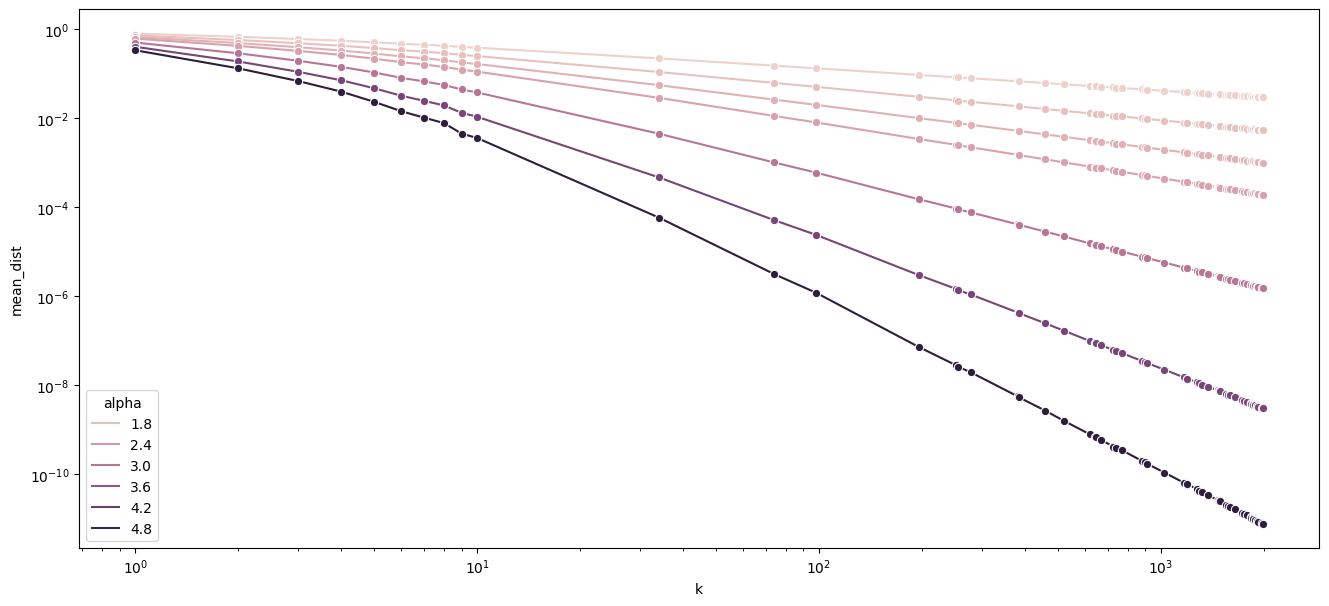

In [19]:
plt.figure(figsize=(16, 7))
sns.lineplot(x="k", y="mean_dist", hue="alpha", data=df, marker="o")
plt.xscale("log")
plt.yscale("log")
plt.show()

Para la elección del ancho de banda $h$ es necesario saber la escala de las distancias! Con qué se come esto???

In [20]:
results = []
for i in range(10000):
    s = rnd.rand(100)
    s.sort()
    dists = (np.array([s[0], *(s[1:] - s[:-1]), 1 - s[-1]])) ** 2
    results.append((dists.mean(), dists.std()))

In [21]:
np.mean([std / mean for mean, std in results])

2.0530978398295896

## Implementación KDEClassifier

In [22]:
from scipy.stats import norm
from numpy.linalg import norm as euclidean_norm
from scipy.spatial import distance_matrix


In [23]:
import scipy
scipy.spatial.distance.minkowski(A[0], A[2])

0.5810266829405176

In [25]:
repr(Fermat)

"<class 'fermat.Fermat.Fermat'>"

In [26]:
B = range(5)
C = range(7)
[[b * c for c in C] for b in B]

[[0, 0, 0, 0, 0, 0, 0],
 [0, 1, 2, 3, 4, 5, 6],
 [0, 2, 4, 6, 8, 10, 12],
 [0, 3, 6, 9, 12, 15, 18],
 [0, 4, 8, 12, 16, 20, 24]]

In [27]:
(A[:] == A[2]).all(1)[:5]

array([False, False,  True, False, False])

In [28]:
A.shape, np.zeros(10)

((1000, 1491), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [29]:
# WIP - ignore
def euclidean_distance(x, y):
    return euclidean_norm(x - y)


class FermatDistance(Fermat):
    def __init__(self, **kwargs):
        super.__init__(**kwargs)

    def _fit(self, X):
        self.fit(X)
        self.X_ = X
        self.n_, self.d_ = X.shape
        self.is_fitted_ = True
        return self

    def __call__(A, B):
        if self.alpha == 1:
            return distance_matrix(A, B)
        else:
            return [[self._get_distance(a, b) for a in A] for b in B]

    def _get_distance(a, b):
        if not self.is_fitted_:
            self._fit()
        if any((self.X_[:] == a).all(1)):  # `a` is a node from X_
            to_X = np.zeros(self.n_)
        else:
            to_X = euclidean_distances(a.reshape(1, -1), verts)[0] ** self.alpha

        if a_known := np.where((X[:] == 2 * X[2]).all(1)):
            to_nodes = euclidean_distances(a.reshape(1, -1), verts)[0] ** alpha


In [30]:
norm_pdf = scipy.stats.norm.pdf

class EuclideanKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            distance_matrix(X, self.X_) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities


In [31]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y#, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from scipy.special import softmax


class EuclideanKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1):
        self.kernel = kernel
        self.bandwith = bandwith

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: EuclideanKDE(self.kernel, self.bandwith).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [32]:
class FermatKDE:
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X):
        self.X_ = X
        self.n_, self.dim_ = X.shape
        self.fermat_ = Fermat(self.alpha, self.path_method).fit(distance_matrix(X, X))
        self.distances_ = self.fermat_.get_distances()
        return self

    def density(self, X, log=True):
        densities = (self.bandwith**-self.dim_) * self.kernel(
            self.distances(X) / self.bandwith
        ).mean(axis=1)
        return np.log(densities) if log else densities

    def distances(self, X):
        distances_to_X = distance_matrix(X, self.X_) ** self.alpha
        return np.vstack([(d + self.distances_).min(axis=1) for d in distances_to_X])


In [33]:
from scipy.special import softmax


class FermatKDEClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, kernel=norm_pdf, bandwith=1, alpha=2, path_method="FW"):
        self.kernel = kernel
        self.bandwith = bandwith
        self.alpha = alpha
        self.path_method = path_method

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)
        self.X_ = X
        self.y_ = y
        self.densities_ = {
            cls: FermatKDE(
                self.kernel, self.bandwith, self.alpha, self.path_method
            ).fit(X[y == cls])
            for cls in self.classes_
        }
        return self

    def decision_function(self, X):
        return np.column_stack(
            [self.densities_[cls].density(X) for cls in self.classes_]
        )

    def predict(self, X):
        D = self.decision_function(X)
        return self.classes_[np.argmax(D, axis=1)]

    def predict_proba(self, X, temp=1):
        D = self.decision_function(X)
        return softmax(D / temp, axis=1)


In [34]:
A = np.array([[i] * 2 for i in range(3)])
Fermat(2, "FW").fit(distance_matrix(A, A)).get_distances()

array([[0., 2., 4.],
       [2., 0., 2.],
       [4., 2., 0.]])

In [35]:
B = np.vstack([[-1, 0], [1, 0]])
B

array([[-1,  0],
       [ 1,  0]])

In [36]:
C = np.vstack([A, B])

In [37]:
full = Fermat(2, "FW").fit(distance_matrix(C, C))
full_dists = full.get_distances()

In [38]:
n_train = 120
train = FermatKDE(2, "FW").fit(A)
test_dists = train.distances(B)

In [39]:
full_dists, test_dists

(array([[0., 2., 4., 1., 1.],
        [2., 0., 2., 3., 1.],
        [4., 2., 0., 5., 3.],
        [1., 3., 5., 0., 2.],
        [1., 1., 3., 2., 0.]]),
 array([[1., 3., 5.],
        [1., 1., 3.]]))

In [41]:
X, y = load_iris(return_X_y=True, as_frame=True)
full = Fermat(2, "FW").fit(distance_matrix(X, X))
full_dists = full.get_distances()

In [42]:
n_train = 120
train = FermatKDE(2, "FW").fit(X[:n_train])
test_dists = train.distances(X[n_train:])

In [43]:
np.where(full_dists[n_train:,:n_train] > test_dists + 0.001)

(array([22]), array([101]))

In [44]:
full_dists[n_train:,:n_train][22, 101],  test_dists[22, 101]

(0.1399999999999999, 0.0)

In [45]:
pd.Series((full_dists[n_train:,:n_train] - test_dists).flatten()).describe()

count    3.600000e+03
mean    -7.726667e-02
std      7.876425e-02
min     -4.600000e-01
25%     -1.200000e-01
50%     -6.000000e-02
75%     -4.440892e-16
max      1.400000e-01
dtype: float64

In [46]:
# Fermat distnaces between train obss, with X=train osbs, must be >= than
#   Fermat distances bw train obss, with X=(train obss + test obss)
assert (train.distances_ >= full_dists[:n_train, :n_train]).all() 

```python
preds = []
fhats = []
for x in X_test:
    fhat = {}
    for cls in classes.keys():
        klass = classes[cls]
        verts, dists = klass["verts"], klass["dists"]
        n = verts.shape[0]
        to_verts = euclidean_distances(x.reshape(1, -1), verts)[0] ** alpha
        fmt_dists = [min(to_verts + dists[:, i]) for i in range(n)]
        # print(cls, np.mean(fmt_dists))
        fhat[cls] = (1 / h**D) * np.mean([kern(d / h) for d in fmt_dists])
    fhats.append(fhat)
    preds.append(pd.Series(fhat).argmax())
```

In [47]:
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [48]:
X, y = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.90)
eucclf = EuclideanKDEClassifier().fit(X_train, y_train)
fmtclf = FermatKDEClassifier(alpha=2, bandwith=200).fit(X_train, y_train)
rfclf = RandomForestClassifier().fit(X_train, y_train)
rfclf2 = RandomForestClassifier().fit(np.concatenate([X_train, fmtclf.decision_function(X_train)], axis=1), y_train)


In [49]:
for clf in [eucclf, fmtclf, rfclf]:
    print(repr(clf), ": ", accuracy_score(clf.predict(X_test), y_test))
print(repr(rfclf2), " - enhanced: ", accuracy_score(rfclf2.predict(np.concatenate([X_test, fmtclf.decision_function(X_test)], axis=1)), y_test))

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21585/1728847503.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


EuclideanKDEClassifier() :  0.9604449938195303
FermatKDEClassifier(bandwith=200) :  0.9604449938195303
RandomForestClassifier() :  0.9326328800988876
RandomForestClassifier()  - enhanced:  0.9369592088998764


In [50]:
accuracy_score(eucclf.predict(X_test), y_test), accuracy_score(fmtclf.predict(X_test), y_test)

/var/folders/h3/d7vpv1m17lv29p7dw5y0yy1c0000gn/T/ipykernel_21585/1728847503.py:17: RuntimeWarning: divide by zero encountered in log
  return np.log(densities) if log else densities


(0.9604449938195303, 0.9604449938195303)

In [51]:
[x.shape for x in [X_train, X_test, y_train, y_test]]

[(179, 64), (1618, 64), (179,), (1618,)]

## TemplateClassifier

In [57]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import euclidean_distances
class TemplateClassifier(BaseEstimator, ClassifierMixin):

    def __init__(self, demo_param='demo'):
        self.demo_param = demo_param

    def fit(self, X, y):

        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes_ = unique_labels(y)

        self.X_ = X
        self.y_ = y
        # Return the classifier
        return self

    def predict(self, X):

        # Check if fit has been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)

        closest = np.argmin(euclidean_distances(X, self.X_), axis=1)
        return self.y_[closest]


In [60]:
unique_labels(y)

array([0, 1, 2])